# POST PROCESSING NOTEBOOK

This python notebook is used to generate effective plots for the results obtained on an X-capacitive accelerometer, accounting for unknown overecth, offset and thickness.

We will start by training the surrogate modelling, plotting the predictions, and then we will start the identiifcation procedure.

##### Importing Necessary Libraries

In [1]:
import sys
sys.path.append('../../../src/SurrogateModeling')
sys.path.append('../../../src/utils/')

from model import NN_Model
from training import train
from preprocessing import preprocessing
from plotting import plot_dataset, plot_predictions, plot_correlation_sensitivity


## First Surrogate Model training

We start training the surrogate model, in order to do so we use the corresponding configuration file. In addition we set some values in order to hide confidential information in the plots.

In [2]:
# CONFIGURATION FILE
CONFIGURATION_FILE = '../config_I.json'

mean_overetch = 0.3
mean_offset = 0.0
mean_thickness= 30.0

sigma_O = 0.2
sigma_U = 0.5
sigma_T = 1.0 


We start importing the dataset, through the preprocessing utility. Then we plot the data, subdivided in validation and training sets

ciao


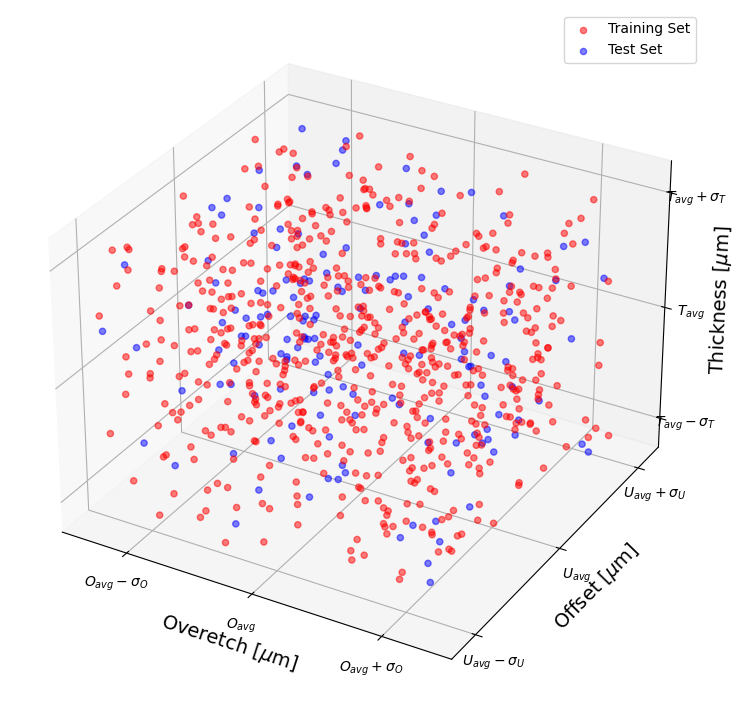

In [8]:
# Preprocessing
data_processor = preprocessing(CONFIGURATION_FILE)

# Configuration parameters
config = data_processor.config

# Collecting traing and Testing Data
X_train = data_processor.X_train
X_test = data_processor.X_test
y_train = data_processor.y_train
y_test = data_processor.y_test

# Time steps of the simulations
time = data_processor.time

# Scaled and processed data
X_train_scaled = data_processor.X_train_scaled
X_test_scaled = data_processor.X_test_scaled 

labels = [
    r'Overetch [${\mu}$m]', 
    r'Offset [${\mu}$m]', 
    r'Thickness [${\mu}$m]'
    ]

ticks = [
    [mean_overetch - sigma_O + 0.05, mean_overetch, mean_overetch + sigma_O - 0.05],
    [mean_offset - sigma_U + 0.05, mean_offset, mean_offset + sigma_U - 0.05],
    [mean_thickness - sigma_T + 0.1, mean_thickness, mean_thickness + sigma_T-0.1]
]

ticks_labels = [
    ['$O_{avg}-\sigma_O$', '$O_{avg}$', '$O_{avg}+\sigma_O$'],
    ['$U_{avg}-\sigma_U$', '$U_{avg}$', '$U_{avg}+\sigma_U$'],
    ['$T_{avg}-\sigma_T$', '$T_{avg}$', '$T_{avg}+\sigma_T$']
]


plot_dataset(X_train, X_test, features_labels=labels, features_ticks=ticks, features_ticks_labels=ticks_labels, digits='%.2f', projection='3d')


### Surrogate Model Training

Then, we train the model. If you want you can use a pretrained model, just changing the flag.

In [4]:
training = False

if training:
    train(config)

model = NN_Model()
model.load_model(config['MODEL_PATH'])

### Accuracy

We now plot the predictions of the surrogate model with respect to real validation data

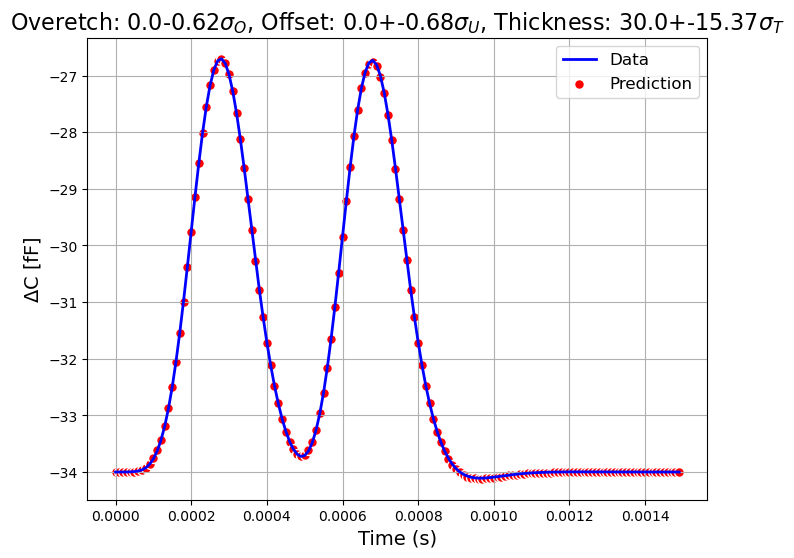

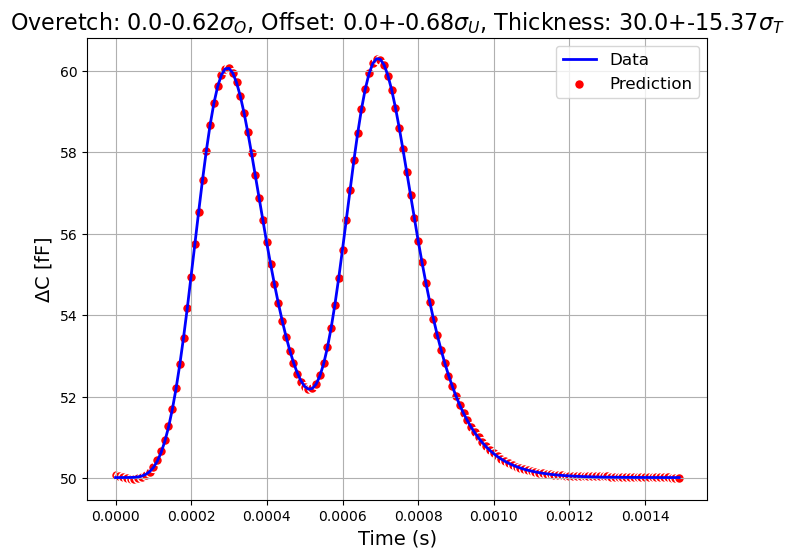

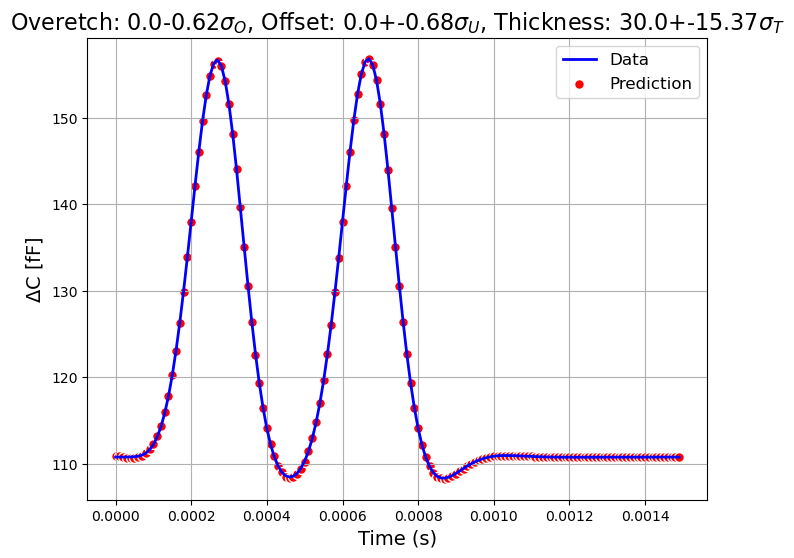

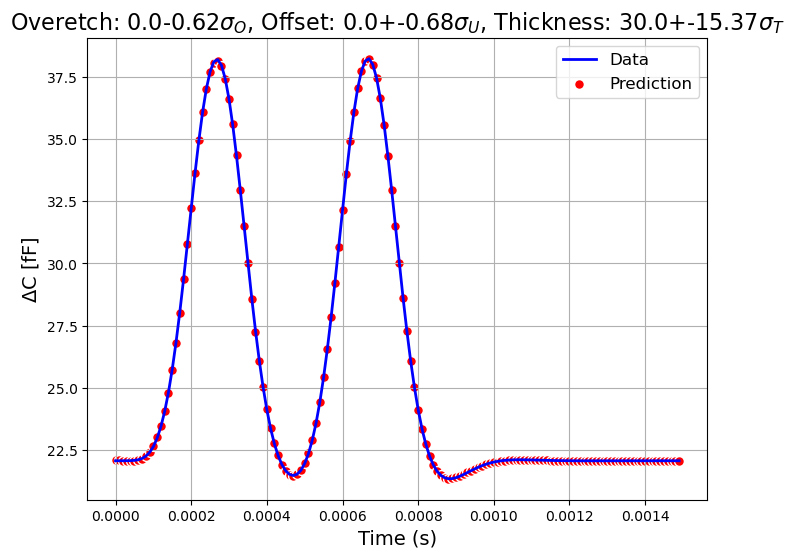

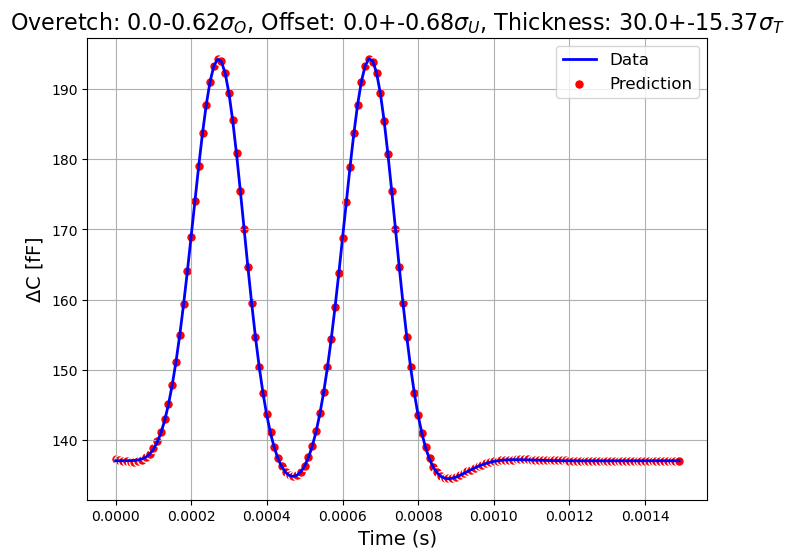

In [10]:
plot_predictions(model, y_test, X_test_scaled, time, max_plots=5)


In [4]:
mean_overetch = 0.3
mean_offset = 0.0
mean_thickness= 30.0

sigma_O = 0.2
sigma_U = 0.5
sigma_T = 1.0        

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')

# Increase marker size and use different markers
ax.scatter(data_processor.X_train[:, 1], data_processor.X_train[:, 2], data_processor.y_train/4.407796, color='b', s=40, marker='o', label='Training data')
ax.scatter(data_processor.X_test[:, 1], data_processor.X_test[:, 2], data_processor.y_test/4.407796, color='r', s=40, marker='^', label='Validation data')

# Improve legibility
# ax.set_xticks([mean_overetch - sigma_O + 0.05, mean_overetch, mean_overetch + sigma_O - 0.05])
# ax.set_xticklabels(['$O_{avg}-\sigma_O$', '$O_{avg}$', '$O_{avg}+\sigma_O$'], fontsize=14)
ax.set_xticks([mean_offset - sigma_U + 0.05, mean_offset, mean_offset + sigma_U - 0.05])
ax.set_xticklabels(['$U_{avg}-\sigma_U$', '$U_{avg}$', '$U_{avg}+\sigma_U$'], fontsize=14)
# Uncomment and adjust z-ticks if needed
ax.set_yticks([mean_thickness - sigma_T+0.05, mean_thickness, mean_thickness + sigma_T-0.05])
ax.set_yticklabels(['$T_{avg}-\sigma_T$', '$T_{avg}$', '$T_{avg}+\sigma_T$'], fontsize=14)

# Axes labels
ax.set_zlabel('S', fontsize=12)

# Legend
ax.legend()

# Gridlines and background
ax.grid(True)
ax.set_facecolor('white')
plt.show()

from scipy.interpolate import griddata

# Example data - replace these with your actual data
x_train, y_train, z_train = data_processor.X_train[:,0], data_processor.X_train[:,2], (data_processor.y_train / 4.407796)
x_test, y_test, z_test = data_processor.X_test[:,0], data_processor.X_test[:,2], (data_processor.y_test / 4.407796)

# Combining training and validation data for interpolation
x = np.concatenate([x_train, x_test])
y = np.concatenate([y_train, y_test])
z = np.concatenate([z_train, z_test])

# Create a meshgrid for the interpolated surface
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate z values on the grid
zi = griddata((x, y), z, (xi, yi), method='linear')

# Plotting
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(xi, yi, zi, cmap='viridis', edgecolor='none', alpha=0.3)
# Scatter plot of the original data points
ax.scatter(x_train, y_train, z_train, color='b', s=20, label='Training data')
ax.scatter(x_test, y_test, z_test, color='r', s=20, label='Validation data')
ax.set_xticks(
ax.set_xticklabels(['$O_{avg}-\sigma_O$', '$O_{avg}$', '$O_{avg}+\sigma_O$'], fontsize=14)
# ax.set_yticks([mean_offset - sigma_U + 0.05, mean_offset, mean_offset + sigma_U - 0.05])
# ax.set_yticklabels(['$U_{avg}-\sigma_U$', '$U_{avg}$', '$U_{avg}+\sigma_U$'], fontsize=14)
ax.set_zlabel('Sensitivity [fF/N]', fontsize=12)
ax.grid(True)
plt.tight_layout()
# Uncomment and adjust z-ticks if needed
ax.set_yticks([mean_thickness - sigma_T + 0.1, mean_thickness, mean_thickness + sigma_T-0.1])
ax.set_yticklabels(['$T_{avg}-\sigma_T$', '$T_{avg}$', '$T_{avg}+\sigma_T$'], fontsize=14)

# Axes labels
ax.legend()

plt.show()



SyntaxError: invalid syntax (2097678049.py, line 68)

In [ ]:
# Test values
overetch_test = np.linspace(0.2, 0.5, 5)
print(overetch_test)
offset_test = np.linspace(-0.1, 0.1, 3)  # Three offset values
thickness_test = np.array([30.0])  # One thickness value

# Time vector
time = np.linspace(0.0, 1.49e-3, 150)

# Prepare the meshgrid for overetch, offset, and thickness
oe, off, th = np.meshgrid(overetch_test, offset_test, thickness_test, indexing='ij')

# Flatten the arrays and combine into a single array for model input
test_data = np.column_stack((oe.flatten(), off.flatten(), th.flatten()))
test_data = np.repeat(test_data,len(time),axis=0)
time_data = np.tile(time,15)
test_data = np.column_stack((test_data,time_data)) 

# Assuming 'data_processor' can scale this test_data and 'model' can predict it
scaled_test_data = data_processor.scaler.transform(test_data)
predictions = model.predict(scaled_test_data)

plt.figure(figsize=(9, 6))
ax = plt.gca()
ax.set_xlabel('Time [ms]', fontsize=14)
ax.set_ylabel(r'${\Delta}C$ [fF]', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Define colormap for 'overetch' values and marker styles for 'offset' values
cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 5)]
print(colors)
norm = Normalize(vmin=overetch_test.min(), vmax=overetch_test.max())
sm = ScalarMappable(norm=norm, cmap=cmap)
marker_styles = ['o', 's', 'D']  # Example marker styles for different offsets
print(test_data)

# Define levels for 'overetch' values and create a norm based on these levels
levels = np.linspace(overetch_test.min(), overetch_test.max(), 6)
norm = BoundaryNorm(levels, ncolors=cmap.N)
off_labels = [r'$U_{avg}-0.1\sigma_U$',r'$U_{avg}$',r'$U_{avg}+0.1\sigma_U$']
print(levels)

# Plot each line with color and marker based on 'overetch' and 'offset' values
for i, (oe_val, off_val, _, _) in enumerate(test_data[0:-1:150,:]):
    color = sm.to_rgba(oe_val)
    marker = marker_styles[i % len(marker_styles)]
    l = off_labels[i % len(marker_styles)] 
    plt.plot(1e3*time_data.reshape(15, 150)[i], predictions.reshape(15, 150)[i], 
            color=color, marker=marker, markevery=10, label=l)

# Reduce the number of legend entries by creating custom labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize=10, labelcolor='black')

# Adjust the colorbar
sm = ScalarMappable(norm=norm, cmap=cmap)
cbar = plt.colorbar(sm, ax=ax, ticks=[levels[0], (levels[2]+levels[3])*0.5, levels[-1]])  # Ticks at min and max
cbar.set_label('Overetch', fontsize=14)

# Set tick labels to show only the min and max values
cbar.set_ticklabels([r'$O_{avg}-\sigma_O$', r'$O_{avg}$', r'$O_{avg}+\sigma_O$'])

plt.grid(True)
plt.tight_layout()
plt.show()

        # Test values
overetch_test = np.array(np.linspace(0.1,0.5,5))
offset_test = np.array([0.2])  # Three offset values
thickness_test = np.linspace(29.0,31.0,5)  # One thickness value

# Time vector
time = np.linspace(0.0, 1.49e-3, 150)

# Prepare the meshgrid for overetch, offset, and thickness
oe, off, th = np.meshgrid(overetch_test, offset_test, thickness_test, indexing='ij')

# Flatten the arrays and combine into a single array for model input
test_data = np.column_stack((oe.flatten(), off.flatten(), th.flatten()))
test_data = np.repeat(test_data,len(time),axis=0)
time_data = np.tile(time,25)
test_data = np.column_stack((test_data,time_data)) 

# Assuming 'data_processor' can scale this test_data and 'model' can predict it
scaled_test_data = data_processor.scaler.transform(test_data)
predictions = model.predict(scaled_test_data)

plt.figure(figsize=(9, 6))
ax = plt.gca()
ax.set_xlabel('Time [ms]', fontsize=14)
ax.set_ylabel(r'${\Delta}C$ [fF]', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Define colormap for 'overetch' values and marker styles for 'offset' values
cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 5)]
print(colors)
norm = Normalize(vmin=overetch_test.min(), vmax=overetch_test.max())
sm = ScalarMappable(norm=norm, cmap=cmap)
marker_styles = ['o', 's', 'D', 'x', '*']  # Example marker styles for different offsets
# print(test_data)

# Define levels for 'overetch' values and create a norm based on these levels
levels = np.linspace(thickness_test.min(), thickness_test.max(), 6)
norm = BoundaryNorm(levels, ncolors=cmap.N)
off_labels = [r'$O_{avg}-\sigma_O$',r'$O_{avg}-0.5\sigma_O$',r'$O_{avg}$',r'$O_{avg}+0.5\sigma_O$',r'$O_{avg}+\sigma_O$']
print(levels)

# Plot each line with color and marker based on 'overetch' and 'offset' values
for i, (oe_val, _, th_val, _) in enumerate(test_data[0:-1:150,:]):
    print(th_val)
    color = colors[i%len(colors)]
    print(color)
    marker = marker_styles[int(i/5) % len(marker_styles)]
    l = off_labels[int(i/5) % len(marker_styles)] 
    plt.plot(1e3*time_data.reshape(25, 150)[i], predictions.reshape(25, 150)[i], '-', color=color,
                marker=marker, markevery=10, label=l)

# Reduce the number of legend entries by creating custom labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize=10, labelcolor='black')

# Adjust the colorbar
sm = ScalarMappable(norm=norm, cmap=cmap)
cbar = plt.colorbar(sm, ax=ax, ticks=[levels[0], 0.5*(levels[2]+levels[3]), levels[-1]])  # Ticks at min and max
cbar.set_label('Thickness', fontsize=14)

# Set tick labels to show only the min and max values
cbar.set_ticklabels([r'$T_{avg}-\sigma_T$', r'$T_{avg}$', r'$T_{avg}+\sigma_T$'])


plt.grid(True)
plt.tight_layout()
plt.show()